# EXPLORE BIOMODELS

In [1]:
import sirn.constants as cnn
from sirn.model_serializer import ModelSerializer
from sirn.network import Network
import sirn.constants as cn
from sirn.subnet_finder import SubnetFinder

import os 

import copy
import numpy as np
import pandas as pd
from sbmlnetwork import SBMLNetwork
import tellurium as te
from typing import List, Tuple
import matplotlib.pyplot as plt
import tellurium as te

# Helpers

In [2]:
BIOMODEL_DIR = "/Users/jlheller/home/Technical/repos/SBMLModel/data"
BIOMODEL_FIILES = [f for f in os.listdir(BIOMODEL_DIR) if f.endswith(".xml")]

In [3]:
REFERENCE_TEST_MODEL = """
A -> B; 1
B -> C; 1
A = 0
B = 0
"""

In [4]:

TARGET_TEST_MODEL = """
S1 -> S2; 2
S2 -> S3; 2
S3 -> S4; 2
A = 0
B = 0
C = 0
"""

In [5]:
def getBiomodel(biomodel_num:int)->Tuple[str, str]:
    """
    Obtains the BioModels file in roadrunner readable (first return value) and printable (second)
    """
    model_str = "BIOMD000000" + str(biomodel_num).zfill(4) + ".xml"
    ffiles = [f for f in BIOMODEL_FIILES if f == model_str]
    if len(ffiles) != 1:
        raise ValueError(f"Invalid biomodels number: {biomodel_num}")
    path = os.path.join(BIOMODEL_DIR, ffiles[0])
    if not os.path.isfile(path):
        raise ValueError(f"Cannot find file {path}.")
    rr = te.loadSBMLModel(path)
    antimony_printable_str = rr.getAntimony()
    antimony_roadrunner_str = antimony_printable_str.replace("\n", ";")
    return antimony_roadrunner_str, antimony_printable_str

# Tests
antimony_rr_str, antimony_prt_str = getBiomodel(608)
assert(isinstance(antimony_rr_str, str))
assert(isinstance(antimony_prt_str, str))
print("OK!")

OK!


In [6]:
def drawModel(model, is_plot=True):
    if "http" in model:
        rr = te.loadSBMLModel(model)
    else:
        rr = te.loada(model) 
    diagram = SBMLNetwork(rr.getSBML())
    diagram.autolayout()
    if is_plot:
        diagram.draw()

# Tests
drawModel(TARGET_TEST_MODEL, is_plot=False)
#drawModel("https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1603310000/4/BIOMD0000000608_url.xml")
print("OK!")

OK!


In [7]:
def findAntimonySubnet(reference_model:str, target_model:str, is_report:bool=True)->pd.DataFrame:
    """
    Finds a subnet of model2 that is model1.
    """
    reference_network = Network.makeFromAntimonyStr(reference_model)
    target_network = Network.makeFromAntimonyStr(target_model)
    finder = SubnetFinder( [reference_network], [target_network],
                 identity=cn.ID_WEAK)
    df = finder.find(is_report=is_report)
    return df

# Test
df = findAntimonySubnet(REFERENCE_TEST_MODEL, TARGET_TEST_MODEL, is_report=False)
assert(len(df.loc[0, 'reference_network']) > 0)
print("OK!")

OK!


In [8]:
#print(df.loc[0, 'reference_network'])

In [9]:
#print(df.loc[0, 'induced_network'])

# Initial Analysis

In [10]:
MODEL_DIR = "/Users/jlheller/home/Technical/repos/sirn/data"
SERIALIZATION_FILE = os.path.join(MODEL_DIR, "biomodels_serialized.txt")

In [11]:
serializer = ModelSerializer(MODEL_DIR, serialization_file=SERIALIZATION_FILE)
network_collection = serializer.deserialize()
BIOMODEL_NETWORKS = network_collection.networks

In [12]:
num_reactions = [n.num_reaction for n in network_collection.networks]
num_species = [n.num_species for n in network_collection.networks]

/var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/ipykernel_1801/1375890876.py:1: RuntimeWarning:

divide by zero encountered in log10



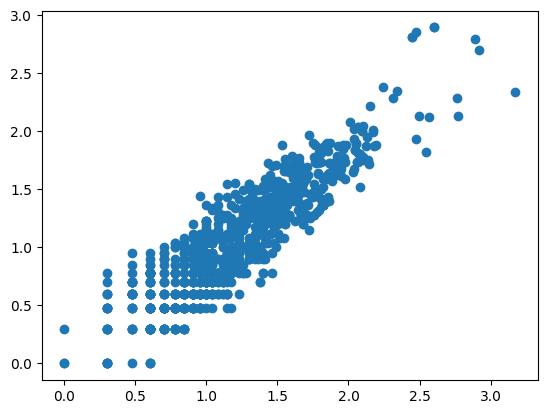

In [13]:
plt.scatter(np.log10(num_reactions), np.log10(num_species))

# Oscillator

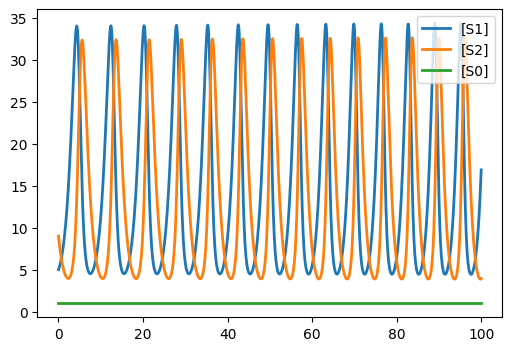

In [14]:
oscillator_model = """
S1 + S2 -> S1 + S1; k1*S1*S2
S2 -> S2 + S2; k2*S2
S0 + S1 -> S0; k3*S0*S1
k1 = 9.63869
k2 = 140.9346
k3 = 130.1286
S0 = 1.0
S1 = 5.0
S2 = 9.0
"""
rr = te.loada(oscillator_model)
rr.simulate(0, 100, 1000)
rr.plot()

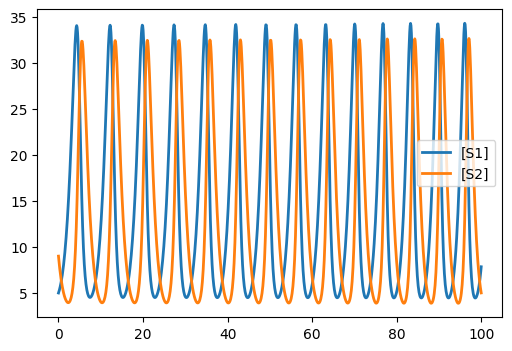

In [15]:
oscillator_model = """
J1: S1 + S2 -> S1 + S1; k1*S1*S2
J2: S2 -> S2 + S2; k2*S2
J3: S1 -> ; k3*S1
k1 = 9.63869
k2 = 140.9346
k3 = 130.1286
S0 = 1.0
S1 = 5.0
S2 = 9.0
"""
rr = te.loada(oscillator_model)
rr.simulate(0, 100, 1000)
rr.plot()

In [16]:
oscillator_network = Network.makeFromAntimonyStr(oscillator_model)
print(oscillator_network)

6985175: 2 species, 3 reactions
  J1: S1 + S2 -> 2.0 S1
  J2: S2 -> 2.0 S2
  J3: S1 -> 


In [17]:
oscillator_network.isStructurallyIdentical(BIOMODEL_NETWORKS[0])

StructurallyIdenticalResult(assignment_pairs=[]; is_truncated=False;

In [18]:
%%time
if False:
    for network in BIOMODEL_NETWORKS:
        if network:
            result = oscillator_network.isStructurallyIdentical(network)
            if result:
                print("Found a match")
                break
        

CPU times: user 9 µs, sys: 49 µs, total: 58 µs
Wall time: 10 µs


# Creating networks of oscillators

In [19]:
!pwd

/Users/jlheller/home/Technical/repos/sirn/notebooks


In [20]:
OSCILLATOR_SERIAIZED_FILE = "/Users/jlheller/home/Technical/repos/sirn/data/Oscillators_June_11_A_2024_6877_serializers.txt"

In [21]:
serializer = ModelSerializer(MODEL_DIR, serialization_file=OSCILLATOR_SERIAIZED_FILE)
oscillator_collection = serializer.deserialize()

In [22]:
len(oscillator_collection)

6877

In [39]:
def searchBiomodels(oscillator_networks):
    matched_result = []
    ignore_count = 165
    for idx, o_network in enumerate(oscillator_networks):
        if idx < ignore_count:
            continue
        print(f"Processing oscillator network {o_network.network_name}")
        for b_idx, b_network in enumerate(BIOMODEL_NETWORKS):
            if b_network:
                print(b_network.network_name, o_network.network_name)
                import pdb; pdb.set_trace()
                result = o_network.isStructurallyIdentical(b_network, is_subset=True, identity=cn.ID_WEAK)
                if result:
                    matched_result.append((o_network, b_network, result))
                    print(f"Found match for {idx} {o_network.network_name}, {b_network.network_name}")

In [40]:
searchBiomodels(oscillator_collection.networks)

Processing oscillator network M9ODQLMW_XrH3X2B_4148_25
BIOMD0000000634 M9ODQLMW_XrH3X2B_4148_25
> /var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/ipykernel_1801/2444393682.py(12)searchBiomodels()
     10                 print(b_network.network_name, o_network.network_name)
     11                 import pdb; pdb.set_trace()
---> 12                 result = o_network.isStructurallyIdentical(b_network, is_subset=True, identity=cn.ID_WEAK)
     13                 if result:
     14                     matched_result.append((o_network, b_network, result))



ipdb>  c


BIOMD0000000152 M9ODQLMW_XrH3X2B_4148_25
> /var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/ipykernel_1801/2444393682.py(11)searchBiomodels()
      9             if b_network:
     10                 print(b_network.network_name, o_network.network_name)
---> 11                 import pdb; pdb.set_trace()
     12                 result = o_network.isStructurallyIdentical(b_network, is_subset=True, identity=cn.ID_WEAK)
     13                 if result:



ipdb>  c


BIOMD0000000146 M9ODQLMW_XrH3X2B_4148_25
> /var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/ipykernel_1801/2444393682.py(12)searchBiomodels()
     10                 print(b_network.network_name, o_network.network_name)
     11                 import pdb; pdb.set_trace()
---> 12                 result = o_network.isStructurallyIdentical(b_network, is_subset=True, identity=cn.ID_WEAK)
     13                 if result:
     14                     matched_result.append((o_network, b_network, result))



ipdb>  c


BIOMD0000000620 M9ODQLMW_XrH3X2B_4148_25
> /var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/ipykernel_1801/2444393682.py(11)searchBiomodels()
      9             if b_network:
     10                 print(b_network.network_name, o_network.network_name)
---> 11                 import pdb; pdb.set_trace()
     12                 result = o_network.isStructurallyIdentical(b_network, is_subset=True, identity=cn.ID_WEAK)
     13                 if result:



ipdb>  c


BIOMD0000000608 M9ODQLMW_XrH3X2B_4148_25
> /var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/ipykernel_1801/2444393682.py(12)searchBiomodels()
     10                 print(b_network.network_name, o_network.network_name)
     11                 import pdb; pdb.set_trace()
---> 12                 result = o_network.isStructurallyIdentical(b_network, is_subset=True, identity=cn.ID_WEAK)
     13                 if result:
     14                     matched_result.append((o_network, b_network, result))



ipdb>  b_idx


4


ipdb>  BIOMODEL_NETWORKS[4].network_name


'BIOMD0000000608'


ipdb>  BIOMODEL_NETWORKS[4].network_name, oscillator_collection.networks[idx]


('BIOMD0000000608', M9ODQLMW_XrH3X2B_4148_25: 4 species, 7 reactions
  _J0: S3 -> S2
  _J1: S0 -> S0 + S4
  _J2: S2 + S4 -> S4
  _J3: S2 -> S2 + S0
  _J4: S0 + S4 -> S4
  _J5: S2 -> 2.0 S2
  _J6: S2 + S4 -> S2)


ipdb>  idx


165


ipdb>  BIOMODEL_NETWORKS[4].network_name, oscillator_collection.networks[0]


('BIOMD0000000608', MA9ZZtJD_JaILTAJ_4688_17: 5 species, 11 reactions
  _J0: S1 -> S2 + S0
  _J1: S0 + S1 -> S2
  _J2: 2.0 S2 -> S3
  _J3: S0 + S3 -> S4
  _J4: S2 + S4 -> S3
  _J5: S0 + S4 -> S0
  _J6: S2 + S1 -> 2.0 S0
  _J7: S0 -> 2.0 S2
  _J8: S3 + S1 -> S4
  _J9: S3 + S1 -> S4
  _J10: S2 + S4 -> S4)


ipdb>  idx


165


ipdb>  BIOMODEL_NETWORKS[4].network_name, oscillator_collection.networks[165]


('BIOMD0000000608', M9ODQLMW_XrH3X2B_4148_25: 4 species, 7 reactions
  _J0: S3 -> S2
  _J1: S0 -> S0 + S4
  _J2: S2 + S4 -> S4
  _J3: S2 -> S2 + S0
  _J4: S0 + S4 -> S4
  _J5: S2 -> 2.0 S2
  _J6: S2 + S4 -> S2)


ipdb>  exit


In [ ]:
[(i, n.network_name) for i, n in enumerate(oscillator_collection.networks) if n.network_name == "MrVijviZ_8flbegF_2622_25"]

In [ ]:
#[(i, n.num_species, n.num_reaction) for i, n in enumerate(BIOMODEL_NETWORKS[:20])]

# A matched oscillator network

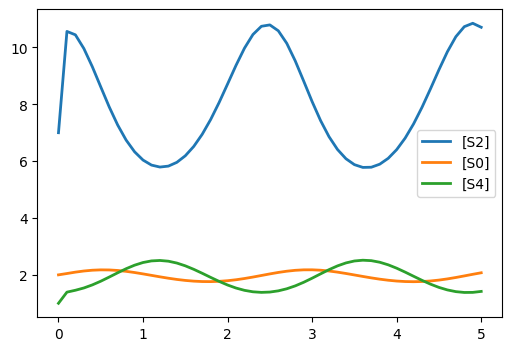

In [103]:
matched_model = """
// M9ODQLMW_XrH3X2B_4148_25
// M9ODQLMW_XrH3X2B_4148_25
// M9ODQLMW_XrH3X2B_4148_25
$S3 -> S2;  S3*19.3591127845924;
S0 -> S4 + S0;  S0*10.3068257839885;
S4 + S2 -> S4;  S4*S2*13.8915863630362;
S2 -> S0 + S2;  S2*0.113616698747501;
S4 + S0 -> S4;  S4*S0*0.240788980014622;
S2 -> S2 + S2;  S2*1.36258363821544;
S2 + S4 -> S2;  S2*S4*1.37438814584166;

S0 = 2; S1 = 5; S2 = 7; S3 = 10; S4 = 1;
"""
rr = te.loada(matched_model)
rr.simulate()
rr.plot()


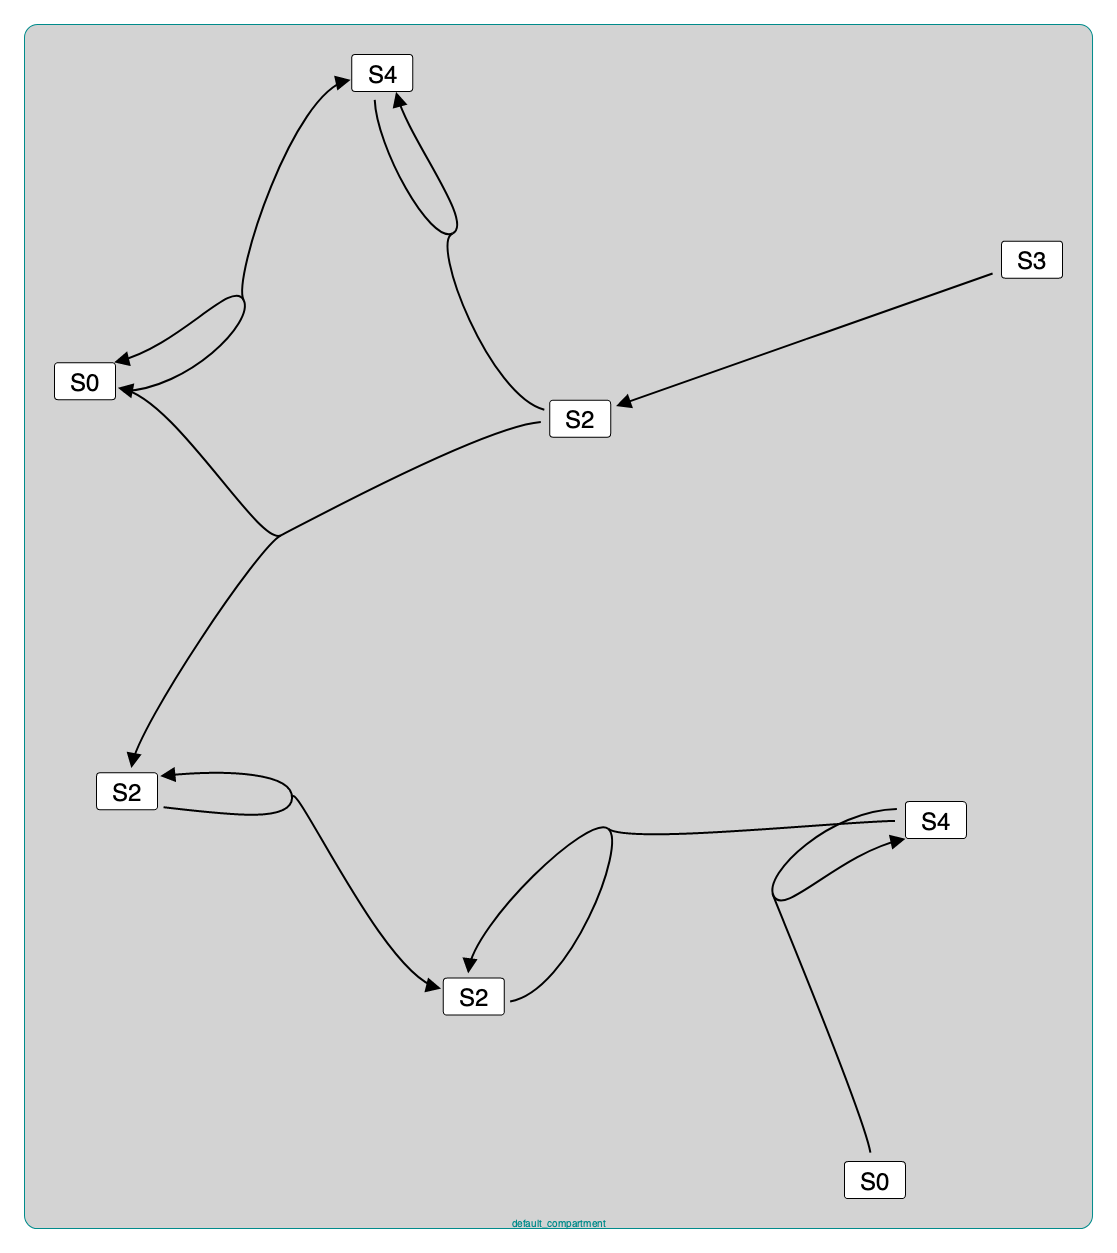

'BIOMD0000000480'

In [102]:

drawModel(matched_model)
target_network = BIOMODEL_NETWORKS[4]
target_network = BIOMODEL_NETWORKS[323]
target_network = BIOMODEL_NETWORKS[383]
target_network = BIOMODEL_NETWORKS[375] # BIOMD 375
reference_network = oscillator_collection.networks[165]
target_network.network_name

In [78]:
%%time
#model, model_prt = getBiomodel(608)
finder = SubnetFinder( [reference_network], [target_network],
                 identity=cn.ID_WEAK)
df = finder.find()
#result = reference_network.isStructurallyIdentical( target_network, is_subset=True, identity=cn.ID_WEAK)
#result

Processing reference model: M9ODQLMW_XrH3X2B_4148_25


assignments: 100%|██████████| 269642210/269642210 [00:16<00:00, 16135295.14it/s]


Found matching model: M9ODQLMW_XrH3X2B_4148_25 and BIOMD0000000480
CPU times: user 9.7 s, sys: 1.52 s, total: 11.2 s
Wall time: 26.6 s


In [79]:
df

,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair,is_truncated
0,M9ODQLMW_XrH3X2B_4148_25,BIOMD0000000480,"M9ODQLMW_XrH3X2B_4148_25: 4 species, 7 reactio...",M9ODQLMW_XrH3X2B_4148_25_BIOMD0000000480: 4 sp...,"{""species_names"": {""S2"": ""species_13"", ""S0"": ""...",150,True


In [56]:
print(df['reference_network'].values[0])

M9ODQLMW_XrH3X2B_4148_25: 4 species, 7 reactions
  _J0: S3 -> S2
  _J1: S0 -> S0 + S4
  _J2: S2 + S4 -> S4
  _J3: S2 -> S2 + S0
  _J4: S0 + S4 -> S4
  _J5: S2 -> 2.0 S2
  _J6: S2 + S4 -> S2


In [57]:
print(df['induced_network'].values[0]) # 26 assignment pairs, 17M assignments, 0.3 sec

M9ODQLMW_XrH3X2B_4148_25_BIOMD0000000695: 4 species, 7 reactions
  R_13: xFinal_8 -> xFinal_7
  R_6: xFinal_3 -> xFinal_3 + xFinal_9
  R_15: xFinal_7 + xFinal_9 -> xFinal_9
  R_24: xFinal_7 -> xFinal_7 + xFinal_3
  R_25: xFinal_3 + xFinal_9 -> xFinal_9
  R_14: xFinal_7 -> 2.0 xFinal_7
  R_7: xFinal_7 + xFinal_9 -> xFinal_7


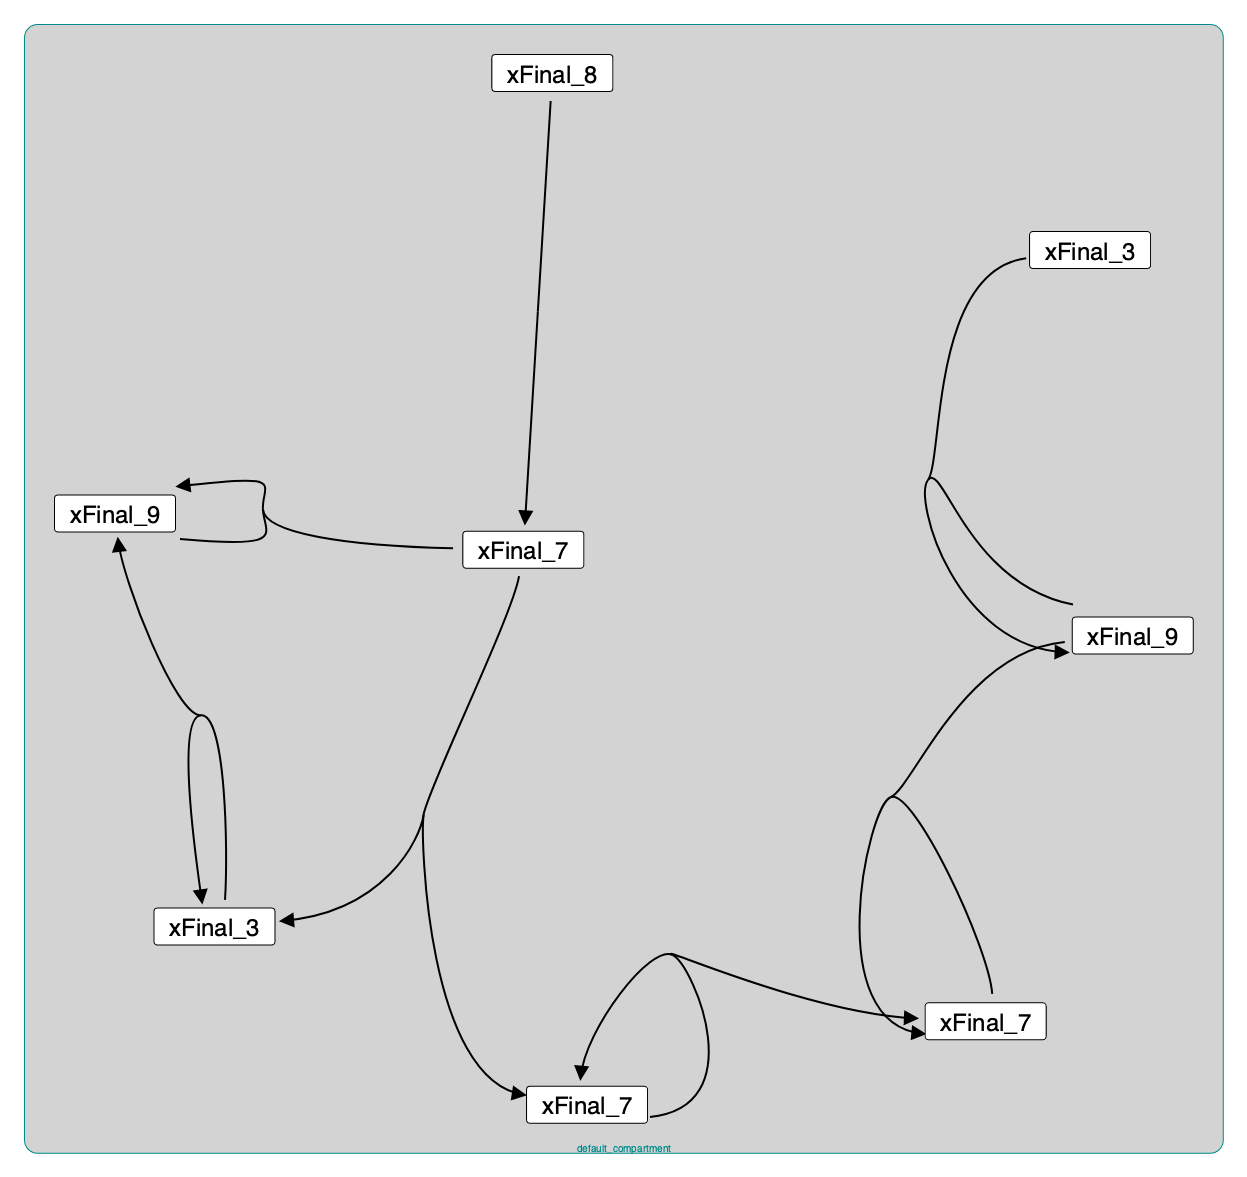

In [75]:
model = """
R_13: xFinal_8 -> xFinal_7; 1
  R_6: xFinal_3 -> xFinal_3 + xFinal_9; 1
  R_15: xFinal_7 + xFinal_9 -> xFinal_9; 1
  R_24: xFinal_7 -> xFinal_7 + xFinal_3; 1
  R_25: xFinal_3 + xFinal_9 -> xFinal_9; 1
  R_14: xFinal_7 -> 2.0 xFinal_7; 1
  R_7: xFinal_7 + xFinal_9 -> xFinal_7; 1
"""
drawModel(model)

In [67]:
print(df['induced_network'].values[0]) # 150 assignment pairs, 270M assignments, 8.85 sec

M9ODQLMW_XrH3X2B_4148_25_BIOMD0000000480: 4 species, 7 reactions
  reaction_16: s1 -> s6
  reaction_30: s16 -> s16 + s13
  reaction_19: s6 + s13 -> s13
  reaction_33: s6 -> s6 + s16
  reaction_12: s16 + s13 -> s13
  reaction_3: s6 -> 2.0 s6
  reaction_39: s6 + s13 -> s6


In [71]:
print(df['induced_network'].values[0]) # 20 assignment pairs, 1.8M assignments, 0.065 sec

M9ODQLMW_XrH3X2B_4148_25_BIOMD0000000872: 4 species, 7 reactions
  re9: s12 -> s13
  re5: s2 -> s2 + s4
  re14: s13 + s4 -> s4
  re1: s13 -> s13 + s2
  re3: s2 + s4 -> s4
  re24: s13 -> 2.0 s13
  re7: s13 + s4 -> s13


In [68]:
[(i, n.network_name) for i, n in enumerate(BIOMODEL_NETWORKS) if "872" in n.network_name]

[(383, 'BIOMD0000000872')]

Biomodels containing this oscillator:
* 608: Palsson2013 - Fully-integrated immune response model (FIRM). Combines many immune response models. 140 reactions. (4)
* 695: 323 FelixGarza2017, Blue light treatment of psoriasis (35 reactions)
* 480: 375 Carbo2013 - Muscosal immune response during H.pylori infection (56 reactions)
*  reaction_16: s1 -> s6
  reaction_30: s16 -> s16 + s13
  reaction_19: s6 + s13 -> s13
  reaction_33: s6 -> s6 + s16
  reaction_12: s16 + s13 -> s13
  reaction_3: s6 -> 2.0 s6
  reaction_39: s6 + s13 -> s6
* 872: 383 Arnold2011_Farquhar1980RuBisCO-CalvinCycle (17 reactions)

# Bugs

Search failed

In [ ]:
bug_network = """
//MxEPgDl6_VNGt1Ea_4270_5

S0 + S4 -> S4 + S4; S0*S4*0.366761065227911;
S0 + $S2 -> S0 + S0; S0*S2*0.979033777397126;
S4 -> $S1;  S4*0.517079830076545;
S4 -> $S1 + $S3;  S4*1.0408536597155;

S0 = 2; S1 = 5; S2 = 7; S3 = 10; S4 = 1;  
"""

# Hash Group Analysis

In [80]:
network_path = "/Users/jlheller/home/Technical/repos/sirn/data/Oscillators_DOE_JUNE_10_17565_serializers.txt"
network_path = "/Users/jlheller/home/Technical/repos/sirn/data/Oscillators_DOE_JUNE_12_B_41373_serializers.txt"

In [83]:
serializer = ModelSerializer(None, network_path)
collection = serializer.deserialize()
networks = collection.networks

In [87]:
hashes = [n.network_hash for n in networks]
len(hashes), len(np.unique(hashes))

(17565, 15530)

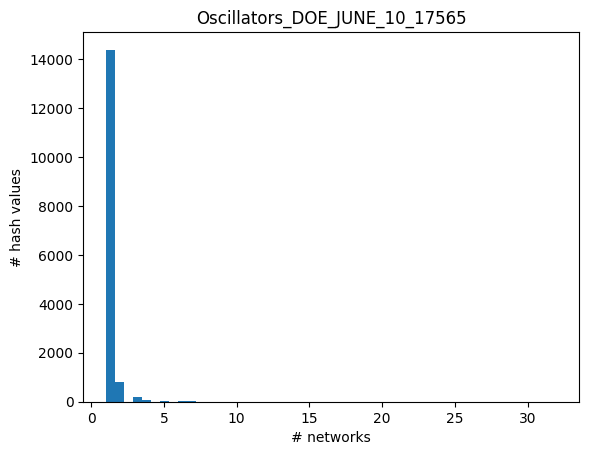

In [101]:
def plotHashInfo(oscillator_dir:str, is_plot=True):
    # Deserialize the network
    network_path = "/Users/jlheller/home/Technical/repos/sirn/data/" + oscillator_dir + "_serializers.txt"
    serializer = ModelSerializer(None, network_path)
    collection = serializer.deserialize()
    networks = collection.networks
    # Extract the size of each hash bin
    hashes = [n.network_hash for n in networks]
    df = pd.DataFrame({'value': hashes})
    dfg = df.groupby('value')
    groups = dfg.groups
    sizes = [len(v) for v in groups.values()]
    # Plot the bin sizes
    _ = plt.hist(sizes, bins=50)
    plt.xlabel("# networks")
    plt.ylabel("# hash values")
    plt.title(oscillator_dir)

# Test
plotHashInfo("Oscillators_DOE_JUNE_10_17565")

Text(0, 0.5, '# hash values')

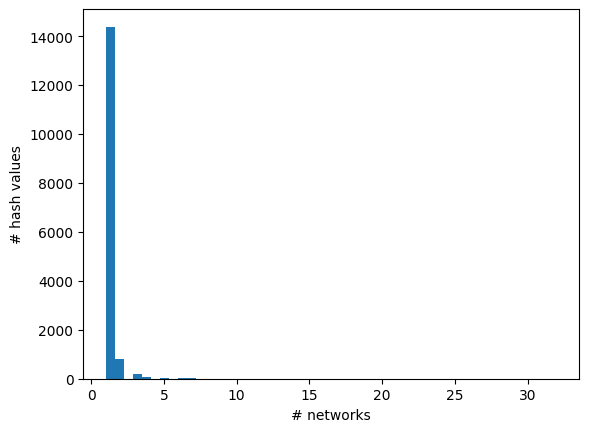

In [98]:
_ = plt.hist(sizes, bins=50)
plt.xlabel("# networks")
plt.ylabel("# hash values")

(array([ 992., 1098., 1361., 1441., 3733., 3952., 1470., 1352., 1228.,
         938.]),
 array([-9.22073759e+18, -7.37654672e+18, -5.53235585e+18, -3.68816498e+18,
        -1.84397411e+18,  2.16761287e+14,  1.84440763e+18,  3.68859850e+18,
         5.53278937e+18,  7.37698024e+18,  9.22117111e+18]),
 <BarContainer object of 10 artists>)

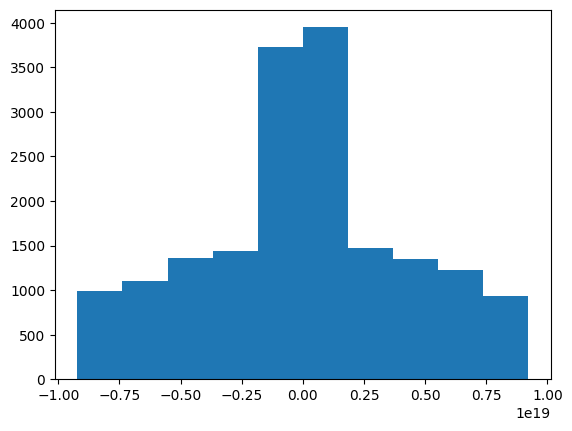

In [86]:
plt.hist(hashes)